In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import statsmodels.formula.api as smf
from statsmodels.stats import multitest
from matplotlib import pyplot as plt
from sklearn.preprocessing import QuantileTransformer

In [35]:
def unique_patients(samples):
    df_samples = pd.DataFrame({ "samples" : samples, 
                            "patient" :["-".join(i.split("-")[:3]) for i in samples] })
    df_samples["plate"] = [i.split("-")[5] for i in df_samples["samples"]]
    df_samples = df_samples.sort_values(by = "plate", ascending= False) \
                .drop_duplicates(subset = "patient", keep = "first")
    return df_samples

def tumor_sample(type):
    meta_data = pd.read_csv("../processed_data/meta/" + type + 
                            "_meta_filtered.csv")
    if type == "CRC":
        df_pt = pd.concat([pd.read_csv("../COAD/filtered_STR/COAD_pt.csv"),
                                pd.read_csv("../READ/filtered_STR/READ_pt.csv")]).reset_index()
    else: 
        df_pt = pd.read_csv("../" + type + "/filtered_STR/" + type + "_pt.csv")

    df_pt = df_pt.loc[df_pt["sample"].isin(meta_data["name"]),]
    # select unique samples 
    unique_pt = unique_patients(df_pt["sample"].unique())
    df_pt = df_pt.loc[df_pt["sample"].isin(unique_pt["samples"])]
    df_pt["patient"] = ["-".join(i.split("-")[:3]) for i in df_pt["sample"]]
    # keep autosomal STRs only 
    df_pt["chr"] = [i.split("_")[0] for i in df_pt["tmp_id"]]
    df_pt = df_pt.loc[~df_pt.chr.isin(["chrM", "chrX", "chrY"]),:]
    
    return df_pt

In [36]:
cancer_type = "CRC"
pt_data = tumor_sample(cancer_type)

In [37]:
pt_data["allele_length"] = (pt_data["allele_a"] + pt_data["allele_b"])/2
pt_str = pt_data.pivot_table(index='tmp_id', columns='patient', values='allele_length')
pt_str = pt_str.loc[pt_str.isna().sum(axis = 1) < pt_str.shape[1]*0.9,]
pt_str = pt_str.loc[pt_str.std(axis = 1) > 0.1,]

In [38]:
str_gene = pd.read_csv("./output/STR_gene_pairs.tsv", sep = "\t")
str_id = pd.DataFrame({"tmp_id" : pt_str.index})
str_id = pd.merge(str_id, str_gene, on = "tmp_id", how = "left")

In [39]:
methyl = pd.read_csv("../methylation/" + cancer_type + "_methyl_pt.tsv", sep = "\t")
methyl.index = methyl["name"]
methyl.drop(columns=["name"], inplace=True)
rmd = unique_patients(methyl.columns)
methyl = methyl[rmd["samples"]]
methyl.columns = rmd["patient"]

In [28]:
quantile_transformer = QuantileTransformer(random_state=42, output_distribution='normal')
norm_methyl = pd.DataFrame(
            quantile_transformer.fit_transform(methyl),
            index = methyl.index,
            columns = methyl.columns)
nrom_methyl = (norm_methyl - norm_methyl.mean())/norm_methyl.std()

In [29]:
methyl_gene = pd.read_csv("../methylation/methyl_anno/methyl_5000.bed", sep = "\t", 
        names = ["gene_chr", "start", "end", "n", "gene", "s", "chr", "pos", "pos1", "name"])[["gene", "name"]]
methyl_gene["gene"] = [i.replace(";", "") for i in methyl_gene["gene"]]

methyl_id = pd.DataFrame({"name": methyl.index})
methyl_id = pd.merge(methyl_id, methyl_gene, on = "name", how = "left")

str_methyl = pd.merge(methyl_id, str_id, left_on = "gene", right_on = "gene_id")
str_methyl["name"] = [i.replace(".", "_") for i in str_methyl["name"]]
norm_methyl.index = [i.replace(".", "_") for i in norm_methyl.index]

In [30]:
crc_str = pd.read_csv("./output/ucec_gene_qtl.csv")
filter_str = crc_str.query(" adj_p < 0.05")
not_estr = crc_str.query(" adj_p >= 0.05 ")

In [31]:
filter_str.shape, not_estr.shape

((108, 6), (16832, 6))

In [32]:
select_pairs = str_methyl.loc[str_methyl["gene"].isin(filter_str["gene"])]
select_pairs = select_pairs.loc[select_pairs["tmp_id"].isin(filter_str["str_id"])]
select_pairs.shape

(2589, 4)

In [12]:
meta_file = pd.read_csv("../processed_data/meta/" + cancer_type + "_meta_no_ffpe.csv")
meta_file["patient"] = ["-".join(i.split("-")[:3]) for i in meta_file["name"]]
meta_file["sample_type"] = [i.split("-")[3][:-1] for i in meta_file["name"]]
pt_samples = meta_file.loc[meta_file["sample_type"] == "01",]
pt_samples = pt_samples.sort_values(by = "plate", ascending= False) \
                .drop_duplicates(subset = "patient", keep = "first")
                
msi_info = pd.read_csv("./output/crc_race_msi.csv")
 #pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
msi_info.loc[msi_info["msi_status"] == "indeterminate", "msi_status"] = "mss"
msi_info = msi_info.merge(pt_samples[["patient", "year"]], on = "patient", how = "left")
msi_info = msi_info[["patient", "gender", "ad_race", "year", "msi_status"]]
msi_info.fillna("unknow", inplace=True)
msi_info["gender"] = msi_info["gender"].replace("'--", "unknow")

In [ ]:
# mapp STR-gene
df_res = {
    "gene" : [],
    "str_id" : [],
    "cg" : [],
    "coef" : [],
    "intercept" : [],
    "p_value" : []
}

p_values = []
coef = []
intercept = []
for i in range(select_pairs.shape[0]):
    print(i)
    m_name, gene, str_name, _ = select_pairs.iloc[i,:]
    one_meth = norm_methyl.loc[m_name,]
    one_str = pt_str.loc[str_name,]
    one_pair = pd.merge(one_meth, one_str, on = "patient")
    one_pair = one_pair.merge(msi_info, on = "patient")
    
    if  one_pair[str_name].nunique() < 3:
        continue
    else:      
        formula = m_name + ' ~ ' + str_name + ' + C(gender) + C(ad_race) + C(year)'
        model = smf.ols(formula, data = one_pair)
        res = model.fit()
        
        df_res["gene"].append(gene)
        df_res["str_id"].append(str_name)
        df_res["cg"].append(m_name)
        df_res["p_value"].append(res.pvalues[str_name])
        df_res["coef"].append(res.params[str_name])
        df_res["intercept"].append(res.params["Intercept"])

In [72]:
df_res = pd.DataFrame(df_res)
df_res["adj_p"] = multitest.multipletests(df_res["p_value"], method = "fdr_bh")[1]
#df_res.to_csv("./methylation/ucec_me_qtl.csv", index = False)

In [380]:
ne_pairs = str_methyl.loc[str_methyl["gene"].isin(not_estr["gene"])]
ne_pairs = ne_pairs.loc[ne_pairs["tmp_id"].isin(not_estr["str_id"])]
ne_pairs.shape

(306061, 4)

In [ ]:
# mapp STR-gene
df_ne_res = {
    "gene" : [],
    "str_id" : [],
    "cg" : [],
    "coef" : [],
    "intercept" : [],
    "p_value" : []
}

p_values = []
coef = []
intercept = []
for i in range(ne_pairs.shape[0]): 
    print(i)
    m_name, gene, str_name, _ = ne_pairs.iloc[i,:]
    one_meth = norm_methyl.loc[m_name,]
    one_str = pt_str.loc[str_name,]
    one_pair = pd.merge(one_meth, one_str, on = "patient")
    one_pair = one_pair.merge(msi_info, on = "patient")
    
    if  one_pair[str_name].nunique() < 3:
        continue
    else:      
        formula = m_name + ' ~ ' + str_name + ' + C(gender) + C(ad_race) + C(year)'
        try:
            model = smf.ols(formula, data = one_pair)
        except ValueError:
            continue
        else:
            res = model.fit()
            
            df_ne_res["gene"].append(gene)
            df_ne_res["str_id"].append(str_name)
            df_ne_res["cg"].append(m_name)
            df_ne_res["p_value"].append(res.pvalues[str_name])
            df_ne_res["coef"].append(res.params[str_name])
            df_ne_res["intercept"].append(res.params["Intercept"])

In [401]:
df_ne_res = pd.DataFrame(df_ne_res)

In [403]:
df_ne_res.to_csv("./methylation/crc_pm.csv", index = False)

In [429]:
filter_str.shape, not_estr.shape

((1411, 6), (11879, 6))

In [ ]:
permu_stats = {
    "all_pairs" : [],
    "all_genes" : [],
    "sig_pairs" : [],
    "sig_genes" : []
}

for i in range(1,4000):
    print(i)
    unestr_list = random.sample(range(not_estr.shape[0]), filter_str.shape[0])
    df_unestr = not_estr.iloc[unestr_list]
    unsig_pairs = str_methyl.loc[str_methyl["gene"].isin(df_unestr["gene"])]
    unsig_pairs = unsig_pairs.loc[unsig_pairs["tmp_id"].isin(df_unestr["str_id"])]

    unsig_res = unsig_pairs.merge(df_ne_res, left_on = ["tmp_id", "name"], right_on = ["str_id", "cg"], how = "inner")
    unsig_res = unsig_res.dropna(subset=["p_value"])
    unsig_res["adj_p"] = multitest.multipletests(unsig_res["p_value"], method = "fdr_bh")[1]
    unsig_test = unsig_res.query("adj_p < 0.05")
    
    permu_stats["all_genes"].append(df_unestr["gene"].nunique())
    permu_stats["all_pairs"].append(unsig_pairs.shape[0])
    permu_stats["sig_pairs"].append(unsig_test.shape[0])
    permu_stats["sig_genes"].append(unsig_test["gene_x"].nunique())

In [433]:
permu_stats = pd.DataFrame(permu_stats)
permu_stats["ratio"] = permu_stats["sig_genes"]/permu_stats["all_genes"]

In [15]:
crc_stats = pd.read_csv("./methylation/crc_permu_stats.csv")

In [442]:
permu_stats.to_csv("./methylation/crc_permu_stats.csv", index=False)

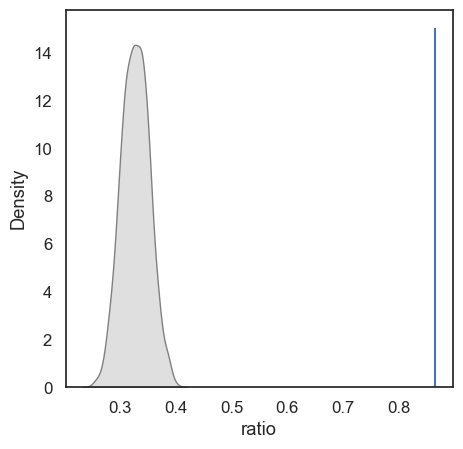

In [408]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi = 100)
sns.set_theme(style = "white", font_scale = 1.1)
axes = sns.kdeplot(x = permu_stats["ratio"], 
                   fill = True, 
                   common_norm= False,
                   color = "grey")
axes.vlines(x = 947/1095, 
            ymin=0,
            ymax = axes.get_ylim()[1],
            color = sns.color_palette()[0])

In [ ]:
# 24025  676  1130   364
# 27193  679  1276   365
# 25166  676  1388   404
# 29806  672  1048   347
# 29456  688  1289   387

In [141]:
unsig_pairs.query("adj_p < 0.05")["gene"].nunique()

387

In [30]:
select_pairs.query("adj_p < 0.05")["gene_id"].nunique()

623

In [121]:
select_qq = pd.DataFrame({"ob_p" : select_pairs.sort_values(by = "p_value")["p_value"], 
                       "exp_p" : np.arange(1, select_pairs.shape[0] + 1) / (select_pairs.shape[0] + 1) })

In [122]:
unsig_qq = pd.DataFrame({"ob_p" : unsig_pairs.sort_values(by = "p_value")["p_value"], 
                       "exp_p" : np.arange(1, unsig_pairs.shape[0] + 1) / (unsig_pairs.shape[0] + 1) })

In [31]:
sig_pairs = select_pairs.query(" adj_p < 0.05")

(-0.5, 0.8)

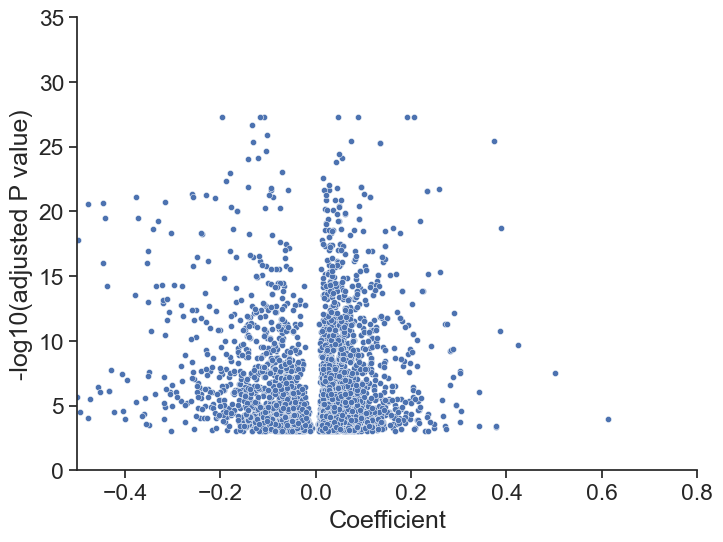

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6), dpi = 100)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.5)
axes = sns.scatterplot(data = sig_pairs , x = "coef", 
                       y = - np.log(sig_pairs["adj_p"]), s = 20) #hue = "region_type",
                       #hue_order = ["intron", "CDS", "UTR", "non-coding exon", "promoter"], 
                       #palette = sns.color_palette("deep")[:5])
axes.set_xlabel("Coefficient")
axes.set_ylabel("-log10(adjusted P value)")
axes.set_ylim(0,35)
axes.set_xlim(-0.5,0.8)
#sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

In [104]:
m_name = "cg24946044"
str_name = "chr6_30580347" 
one_meth = norm_methyl.loc[m_name,]
one_str = pt_str.loc[str_name,]
one_pair = pd.merge(one_meth, one_str, on = "patient")
one_pair = one_pair.merge(msi_info, on = "patient")

In [105]:
formula = m_name + ' ~ ' + 'C(gender) + C(ad_race) + C(year)'
model = smf.ols(formula, data = one_pair).fit()
one_pair["reg_m"] = model.resid

for2 = "reg_m" + '~' + str_name
model2 = smf.ols(for2, data = one_pair)
res2 = model2.fit()

In [106]:
res2.params

Intercept        0.960000
chr6_30580347   -0.036626
dtype: float64

Text(0.5, 1.0, 'cg24946044')

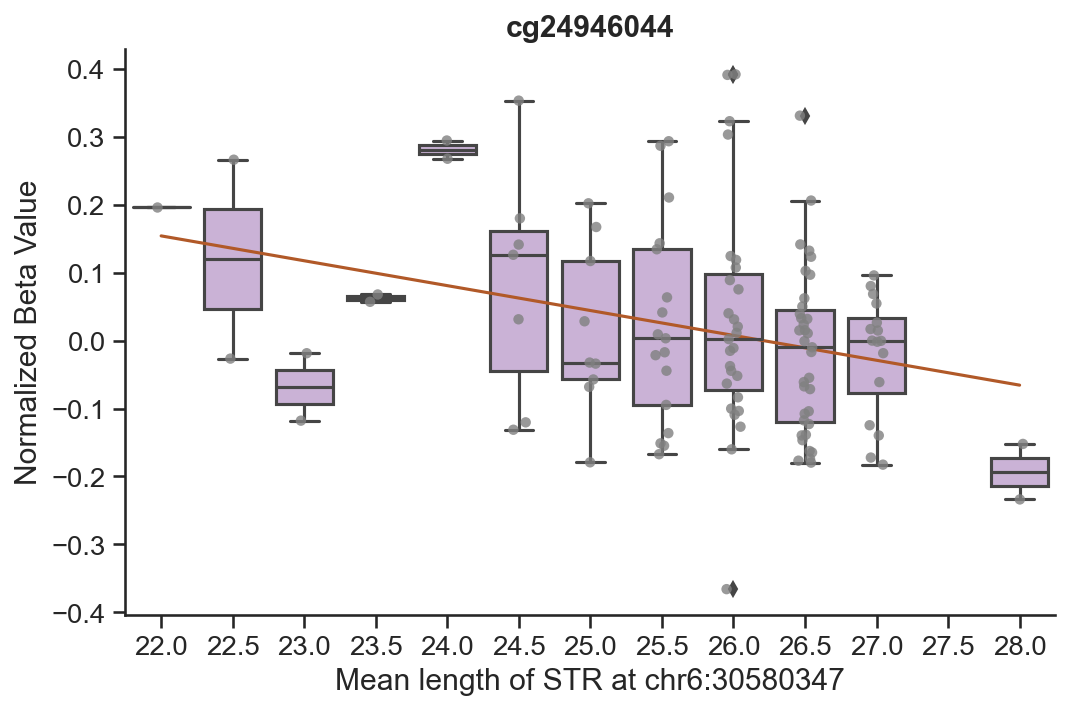

In [107]:
fill_gap = np.setdiff1d(np.arange(one_pair[str_name].min(), one_pair[str_name].max(), 0.5), one_pair[str_name].unique())

filled_data = pd.concat([one_pair[[str_name, "reg_m"]], 
           pd.DataFrame({str_name: fill_gap, "reg_m" : [np.nan]*len(fill_gap)})])

inter, coef = res2.params
#crc_me_qtl.loc[(crc_me_qtl["str_id"] == str_name) & (crc_me_qtl["cg"] == m_name) , ["coef", "intercept"]].values[0]
x1 = 0
x2 = (one_pair[str_name].max() - one_pair[str_name].min())*2
y1 = one_pair[str_name].min()*coef + inter
y2 = one_pair[str_name].max()*coef + inter

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi = 150)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style = "ticks", rc = custom_params, font_scale = 1.2)

sns.boxplot(ax = axes, data = filled_data, x = str_name, y = "reg_m",
            boxprops={'facecolor':sns.color_palette("Paired")[-4]})
sns.stripplot(data = filled_data, x = str_name, y = "reg_m",
             ax = axes, color = "grey", alpha = 0.8)

axes.plot([x1, x2], [y1,y2], color = sns.color_palette("Paired")[-1])
axes.set_xlabel("Mean length of STR at " + str_name.replace("_", ":"))
axes.set_ylabel("Normalized Beta Value")
axes.set_title(m_name, weight = "bold")